In [2]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from skimage.io import imread
from src import *

from src import RGBDataset, RGBDataModule, RGBModule

In [3]:
path = Path("../data")
os.listdir(path)

['metadata',
 'observations',
 'patches-fr',
 'patches-us',
 'patches_sample',
 'pre-extracted',
 'rasters',
 'sample_submission.csv']

In [3]:
pd.read_csv(path / "sample_submission.csv")

,Id,Predicted
0,10000293,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,10000302,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,10000346,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,10000468,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,10000481,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
...,...,...
36416,22067746,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
36417,22067972,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
36418,22068007,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
36419,22068076,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


In [4]:
os.listdir(path / "observations")

['observations_fr_test.csv',
 'observations_fr_train.csv',
 'observations_us_test.csv',
 'observations_us_train.csv']

In [6]:
obs_fr = pd.read_csv(path / 'observations' / 'observations_fr_train.csv', sep=';')
obs_us = pd.read_csv(path / 'observations' / 'observations_us_train.csv', sep=';')
data_train = pd.concat([obs_fr, obs_us])
data_train

,observation_id,latitude,longitude,species_id,subset
0,10561949,45.705116,1.424622,241,train
1,10131188,45.146973,6.416794,101,train
2,10799362,46.783695,-2.072855,700,train
3,10392536,48.604866,-2.825003,1456,train
4,10335049,48.815567,-0.161431,157,train
...,...,...,...,...,...
956226,22068171,29.602327,-94.555860,5041,train
956227,22068172,38.029580,-122.883995,8688,train
956228,22068173,37.913720,-121.948814,12154,train
956229,22068174,37.206974,-122.067154,5309,val


In [6]:
dm = RGBDataModule()
dm.setup()

train: 1587395
val: 40080
test: 36421


In [7]:
dm.data_train

,observation_id,latitude,longitude,species_id,subset,image
0,10561949,45.705116,1.424622,241,train,../data/patches-fr/49/19/10561949_rgb.jpg
1,10131188,45.146973,6.416794,101,train,../data/patches-fr/88/11/10131188_rgb.jpg
2,10799362,46.783695,-2.072855,700,train,../data/patches-fr/62/93/10799362_rgb.jpg
3,10392536,48.604866,-2.825003,1456,train,../data/patches-fr/36/25/10392536_rgb.jpg
4,10335049,48.815567,-0.161431,157,train,../data/patches-fr/49/50/10335049_rgb.jpg
...,...,...,...,...,...,...
956225,22068170,38.205840,-122.758660,8451,train,../data/patches-us/70/81/22068170_rgb.jpg
956226,22068171,29.602327,-94.555860,5041,train,../data/patches-us/71/81/22068171_rgb.jpg
956227,22068172,38.029580,-122.883995,8688,train,../data/patches-us/72/81/22068172_rgb.jpg
956228,22068173,37.913720,-121.948814,12154,train,../data/patches-us/73/81/22068173_rgb.jpg


In [8]:
img, label = dm.ds_train[0]
img.shape, img.dtype, img.max(), img.min(), label

((256, 256, 3), dtype('uint8'), 244, 4, 241)

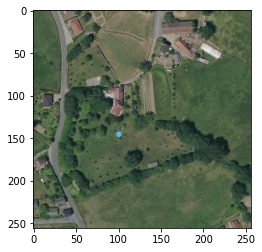

In [9]:
plt.imshow(img)
plt.show()

In [10]:
imgs, labels = next(iter(dm.train_dataloader(batch_size=25)))
imgs.shape, imgs.dtype, imgs.max(), imgs.min(), labels

(torch.Size([25, 256, 256, 3]),
 torch.uint8,
 tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor([2524,  552, 6487,  125, 1012, 1059,  114,  389, 8142,   68, 1749,  119,
          223,  505,  567,  306,  256, 4918,  607,   68,  864, 7282, 2277,   90,
         5207]))

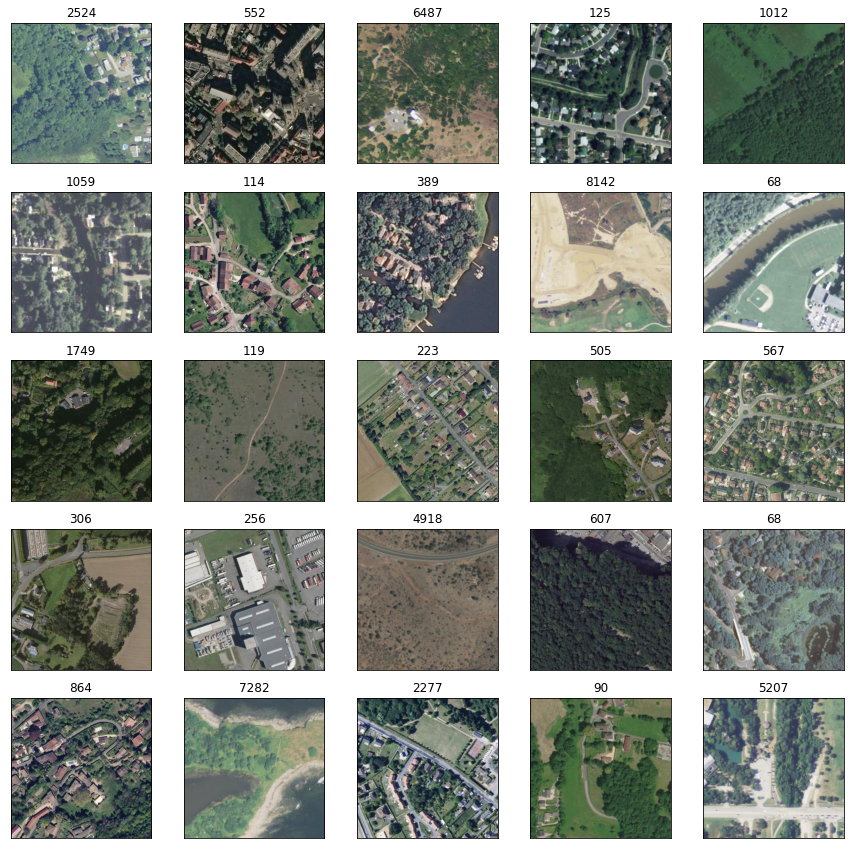

In [11]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(imgs[i])
    ax.set(xticks=[], yticks=[])
    ax.set_title(labels[i].item())
plt.show()

In [17]:
sample = dm.data_train.sample(1).observation_id.iloc[0]
patch = get_patch_rgb(sample)

img_path = path + "/" + str(sample) + "_near_ir.jpg"
img = imread(path / img_path)
plt.imshow(img)
plt.show()
img.shape, img.dtype, img.max(), img.min()

AttributeError: module 'src.dm' has no attribute 'data_train'

In [35]:
!dir ..\data\observations\

 Volume in drive D is Data
 Volume Serial Number is DC63-9003

 Directory of d:\Code\Kaggle_Competitions\GeoLifeCLEF2022\data\observations

03/05/2021  07:57 PM    <DIR>          .
03/05/2021  07:57 PM    <DIR>          ..
02/02/2022  06:57 PM           747,403 observations_fr_test.csv
02/02/2022  07:00 PM        35,692,651 observations_fr_train.csv
02/02/2022  06:57 PM           556,850 observations_us_test.csv
02/02/2022  07:00 PM        38,256,705 observations_us_train.csv
               4 File(s)     75,253,609 bytes
               2 Dir(s)  486,008,143,872 bytes free


In [4]:
df_env = pd.read_csv(path /"pre-extracted" / "environmental_vectors.csv", sep=";", index_col="observation_id")
df_env

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_18,bio_19,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt
observation_id,,,,,,,,,,,,,,,,,,,,,
10000000,1.420833,6.908333,29.272598,614.14930,15.1,-8.5,23.600000,-1.000000,9.183333,9.466667,...,248.0,358.0,2082.0,988.0,29.0,13.0,63.0,62.0,34.0,53.0
10000001,8.837500,9.858334,37.771393,586.81390,23.8,-2.3,26.099998,6.016667,16.383333,16.383333,...,226.0,288.0,1816.0,1142.0,20.0,22.0,39.0,58.0,41.0,36.0
10000002,6.241667,8.350000,32.239384,632.86090,21.0,-4.9,25.900000,3.033333,14.200000,14.200000,...,268.0,317.0,1346.0,1075.0,29.0,22.0,54.0,59.0,40.0,38.0
10000003,12.554167,9.525001,40.189877,541.80865,25.9,2.2,23.699999,6.850000,19.350000,19.350000,...,157.0,257.0,1227.0,1383.0,21.0,28.0,18.0,71.0,46.0,25.0
10000004,8.029167,10.075000,36.636364,633.01750,23.7,-3.8,27.500000,4.616667,16.083334,16.083334,...,214.0,280.0,2833.0,1202.0,24.0,25.0,33.0,69.0,38.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22068171,20.345833,8.958333,34.455128,641.55160,32.4,6.4,26.000002,27.500000,16.450000,27.866667,...,361.0,280.0,2235.0,1593.0,50.0,37.0,83.0,61.0,32.0,31.0
22068172,13.458333,11.566667,63.553116,249.07861,23.3,5.1,18.199999,10.316667,15.883333,16.383333,...,21.0,551.0,2189.0,1281.0,18.0,22.0,57.0,57.0,22.0,56.0
22068173,15.162500,13.191667,49.222637,519.41895,30.5,3.7,26.800000,8.933333,21.150000,21.633333,...,12.0,324.0,322.0,1366.0,29.0,24.0,52.0,63.0,38.0,38.0


In [5]:
df_env.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1663896 entries, 10000000 to 22068176
Data columns (total 27 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   bio_1   1619868 non-null  float64
 1   bio_2   1619868 non-null  float64
 2   bio_3   1619868 non-null  float64
 3   bio_4   1619868 non-null  float64
 4   bio_5   1619868 non-null  float64
 5   bio_6   1619868 non-null  float64
 6   bio_7   1619868 non-null  float64
 7   bio_8   1619868 non-null  float64
 8   bio_9   1619868 non-null  float64
 9   bio_10  1619868 non-null  float64
 10  bio_11  1619868 non-null  float64
 11  bio_12  1619868 non-null  float64
 12  bio_13  1619868 non-null  float64
 13  bio_14  1619868 non-null  float64
 14  bio_15  1619868 non-null  float64
 15  bio_16  1619868 non-null  float64
 16  bio_17  1619868 non-null  float64
 17  bio_18  1619868 non-null  float64
 18  bio_19  1619868 non-null  float64
 19  bdticm  1602774 non-null  float64
 20  bldfie  1602774 

In [7]:
obs_id_train = data_train.observation_id[data_train["subset"] == "train"].values
obs_id_val = data_train.observation_id[data_train["subset"] == "val"].values

X_train = df_env.loc[obs_id_train].values
X_val = df_env.loc[obs_id_val].values

In [8]:
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
])

X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)